In [60]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

import klib

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df2 = pd.concat([df_train, df_test], axis = 0, sort = True)
df_num = df2.select_dtypes(include = ['int64', 'float64'])


In [4]:
df_num.shape

(2919, 38)

In [5]:
# fig, axes = plt.subplots(nrows = 19, ncols = 2, figsize = (40, 200))
# for ax, column in zip(axes.flatten(), df_num.columns):
#     sns.distplot(df_num[column].dropna(), ax = ax, color = 'darkred')
#     ax.set_title(column, fontsize = 43)
#     ax.tick_params(axis = 'both', which = 'major', labelsize = 35)
#     ax.tick_params(axis = 'both', which = 'minor', labelsize = 35)
#     ax.set_xlabel('')
# fig.tight_layout(rect = [0, 0.03, 1, 0.95])

In [6]:
# From the above graphs we get to know that some features are discrete in nature. We need to convert them to 'object' data type.

In [7]:
df2.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']] = df2.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']].astype('object')

In [8]:
df_train = df2.iloc[:1460, :].drop(columns = ['Id'], axis = 1)
df_test = df2.iloc[1460:, :].drop(columns = ['Id', 'SalePrice'], axis = 1)

<h1> Outliers Detection </h1>

In [9]:
df_num2 = df2.select_dtypes(include = ['int64', 'float64'])


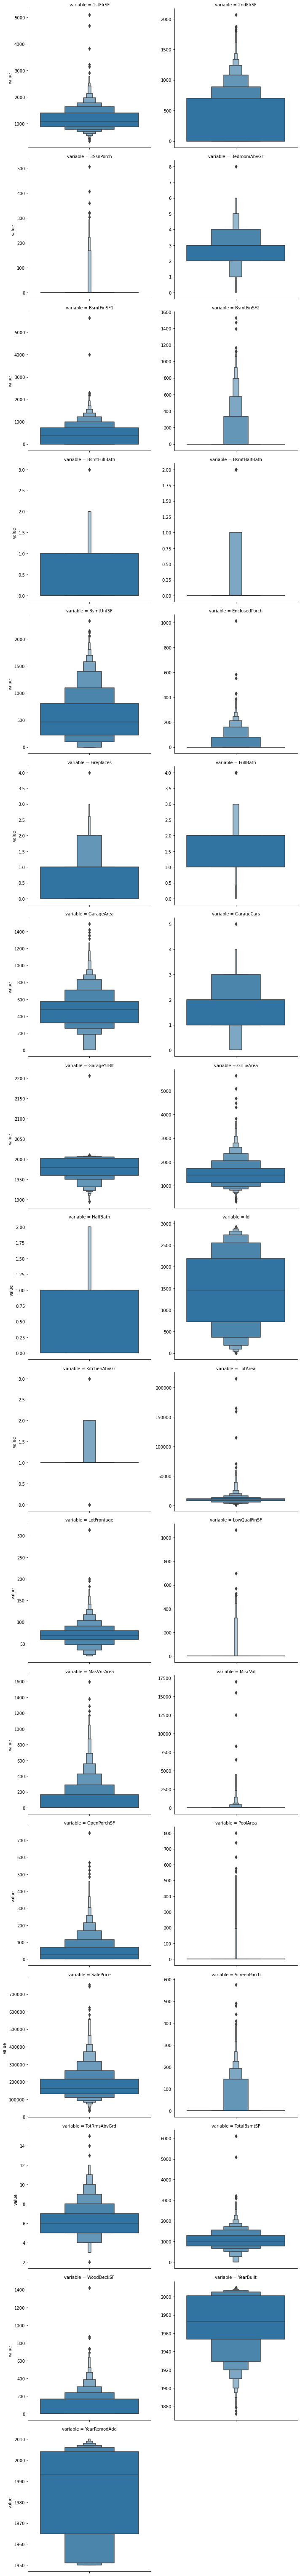

In [11]:
sns.catplot(
    y="value",
    col="variable",
    data=df_num2.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers,

In [12]:
# 1stFlrSF>4000, BsmtFinSF1>3000, EnclosedPorch>800, GarageYrBlt>2100, GrLivArea>4000, TotalBsmtSF>4000, 
df_train.drop(df_train[df_train['1stFlrSF']>4000].index, inplace = True)
df_train.drop(df_train[df_train.BsmtFinSF1>3000].index, inplace = True)
df_train.drop(df_train[df_train.EnclosedPorch>800].index, inplace = True)
df_train.drop(df_train[df_train.GarageYrBlt>2100].index, inplace = True)
df_train.drop(df_train[df_train.GrLivArea>4000].index, inplace = True)
df_train.drop(df_train[df_train.TotalBsmtSF>4000].index, inplace = True)

df_train.reset_index(drop = True, inplace = True)

<h1> Imputing Missing Values</h1>

In [13]:
y_train = df_train.SalePrice
df_train.drop('SalePrice', axis = 1, inplace = True)
df_merged = pd.concat([df_train, df_test], axis = 0)

In [14]:
# Columns with missing values
df_merged.isnull().sum()[df_merged.isnull().sum()>0].index

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SaleType', 'TotalBsmtSF', 'Utilities'],
      dtype='object')

In [15]:
# some columns have 'Na' meaning None i.e 0, by description.

In [16]:
to_impute_by_none = df_merged.loc[:, ['PoolQC','MiscFeature','Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageCond','GarageFinish','GarageQual','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1','MasVnrType']]
for i in to_impute_by_none.columns:
    df_merged[i].fillna('None', inplace = True)

In [17]:
# Categorical features are imputed by 'Mode'
to_impute_by_mode = df_merged.loc[:, ['Electrical', 'MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional', 'SaleType']]
for i in to_impute_by_mode.columns:
    df_merged[i].fillna(df_merged[i].mode()[0], inplace = True)

In [18]:
# Numerical features are imputed by 'Median'
to_impute_by_median = df_merged.loc[:, ['BsmtFullBath','BsmtHalfBath', 'GarageCars', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']]
for i in to_impute_by_median.columns:
    df_merged[i].fillna(df_merged[i].median(), inplace = True)

In [19]:
#Numerical columns with more than 10% missing values should be imputed using median of the category which that column is highly correlated to
#LotFrontage
temp1 = df_merged.select_dtypes(include = 'object')
correlation = temp1.agg(LabelEncoder().fit_transform)
correlation['LotFrontage'] = df_merged.LotFrontage
correlation.corr().LotFrontage.sort_values()

#LotFrontage has maximum correlation with BldgType

df_merged.LotFrontage = df_merged.groupby('BldgType').LotFrontage.transform(lambda x: x.fillna(x.median()))

In [20]:
df_merged.isnull().sum()[df_merged.isnull().sum()>0]

Series([], dtype: int64)

<h1> Transformation of Distribution </h1>

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

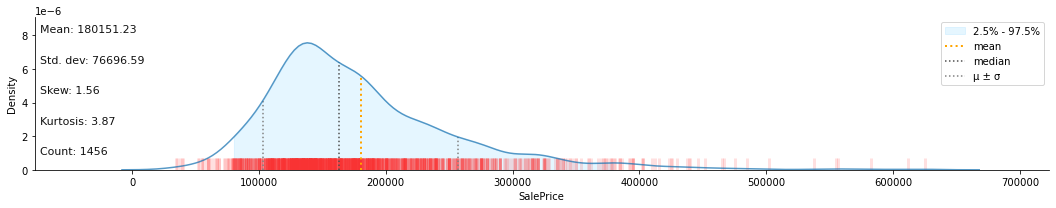

In [21]:
klib.dist_plot(y_train,showall=True)

In [22]:
# Using log transformation to target variable
y_train = np.log1p(y_train)
# klib.dist_plot(y_train,showall=True)

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<AxesSubplot:xlabel='YrSold', ylabel='Density'>

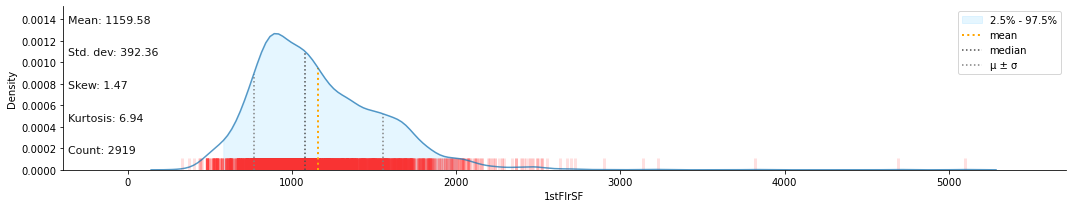

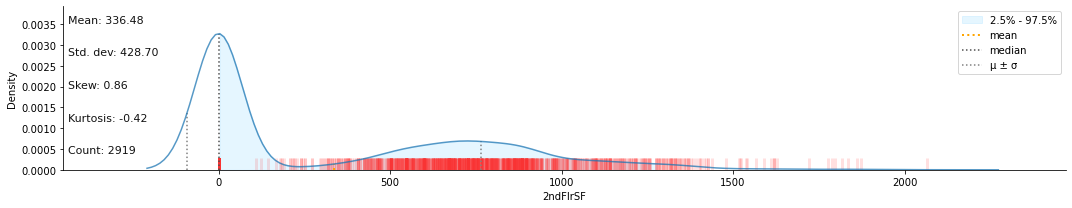

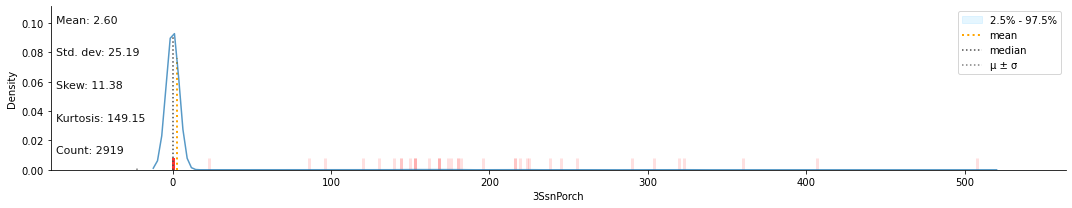

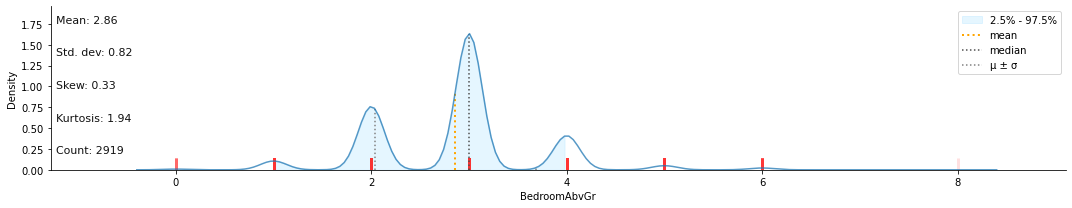

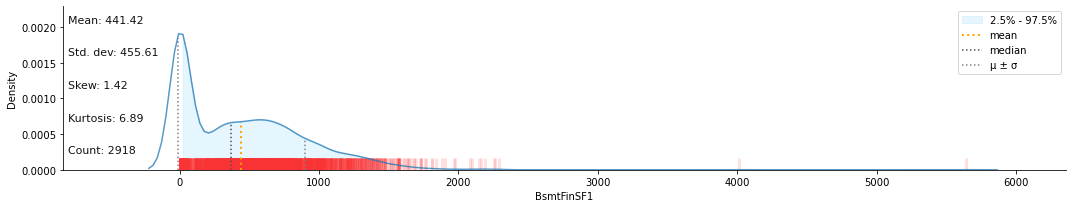

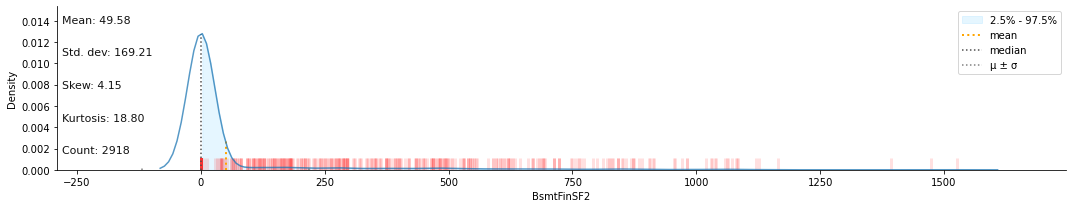

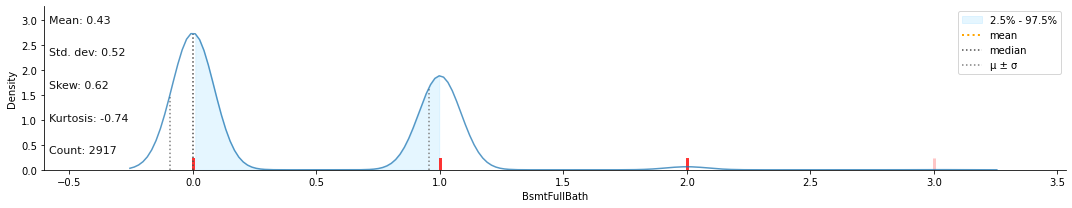

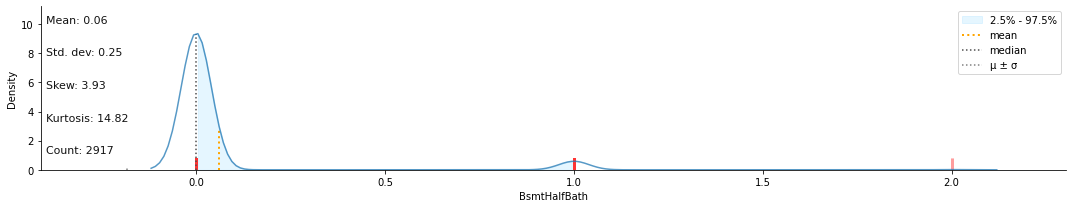

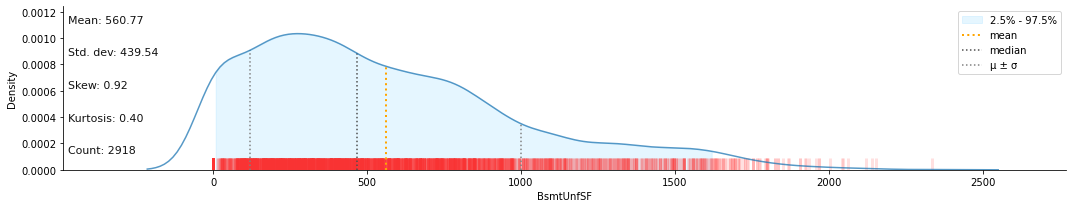

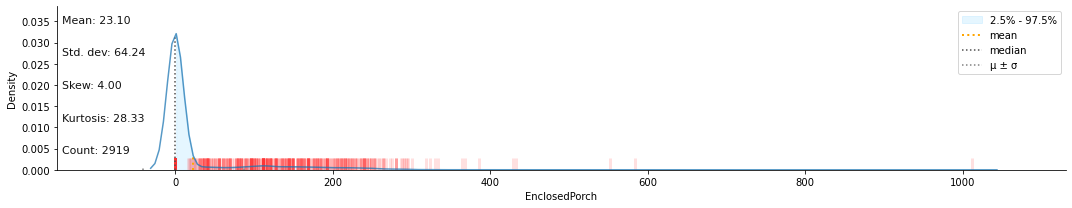

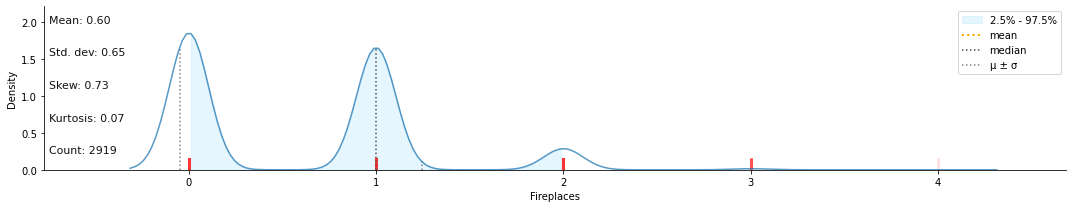

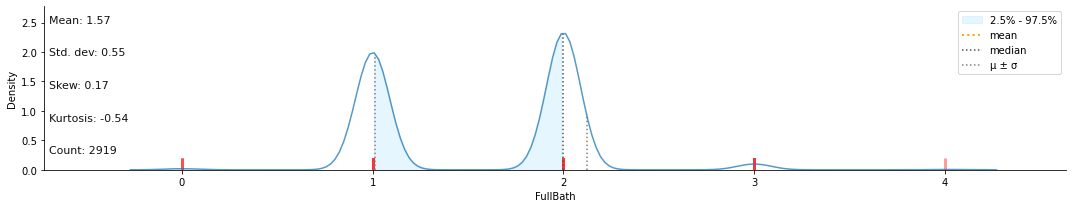

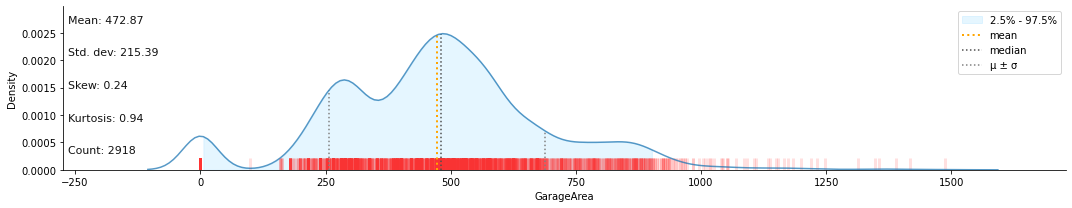

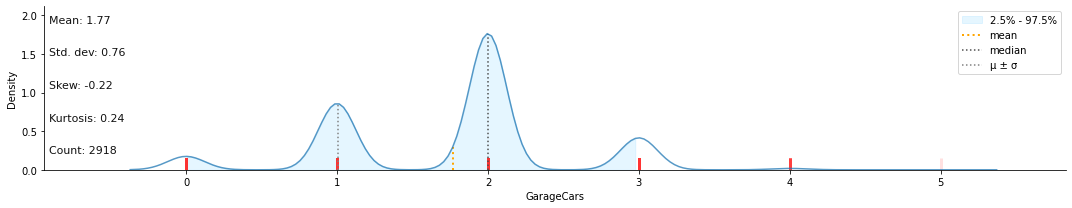

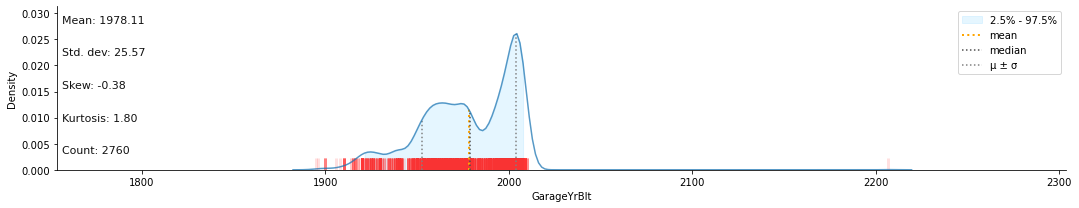

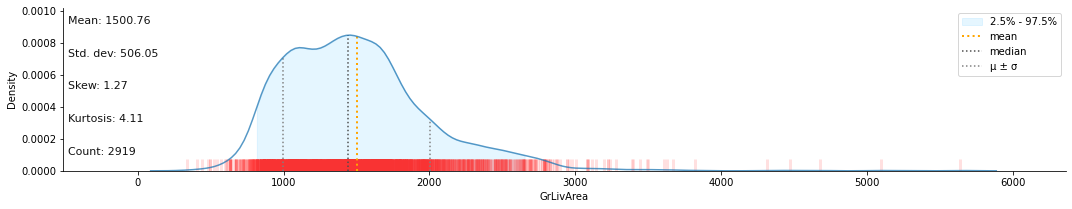

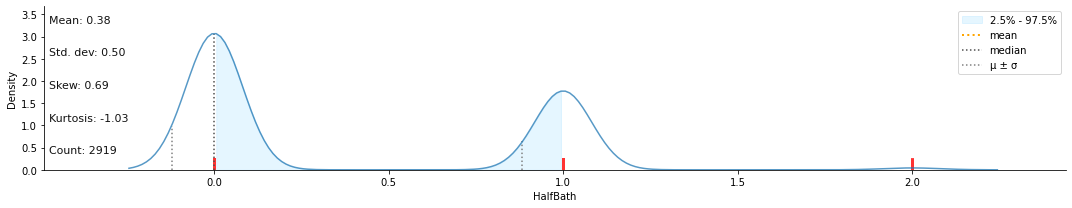

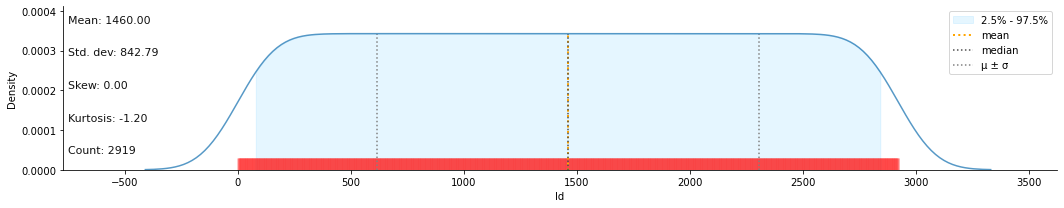

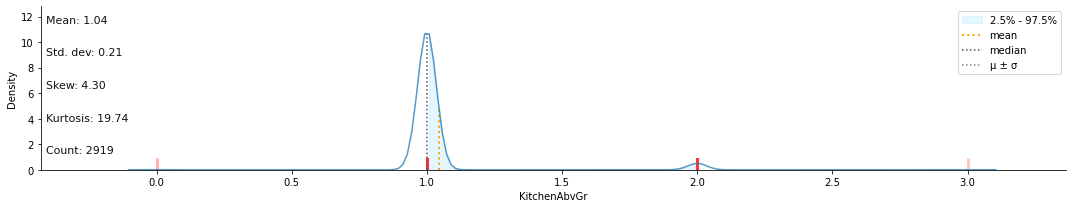

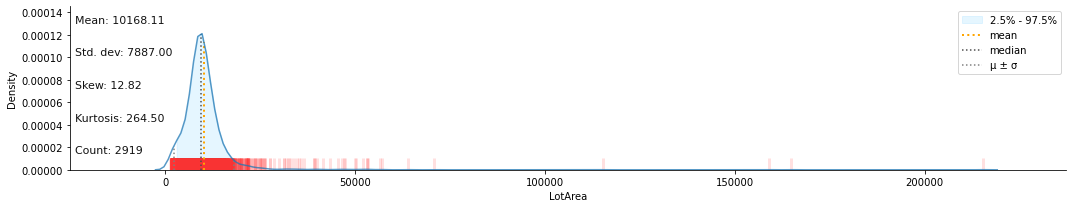

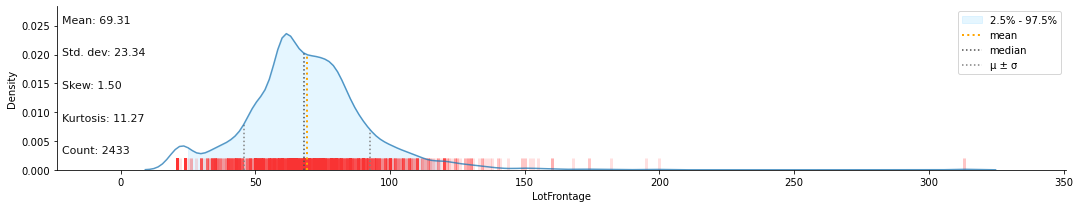

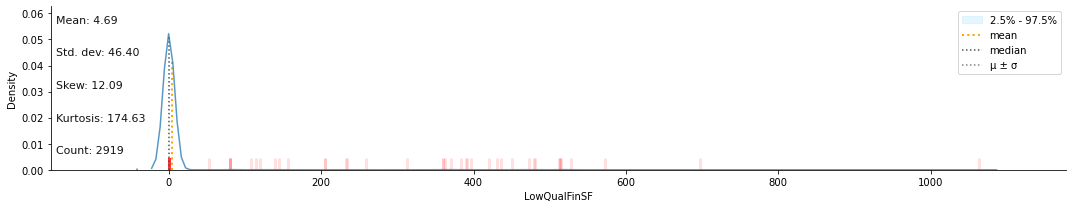

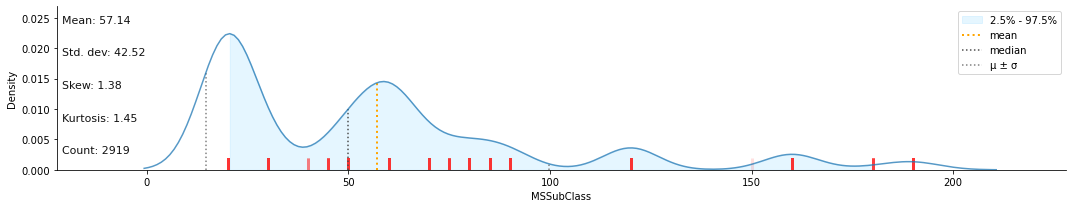

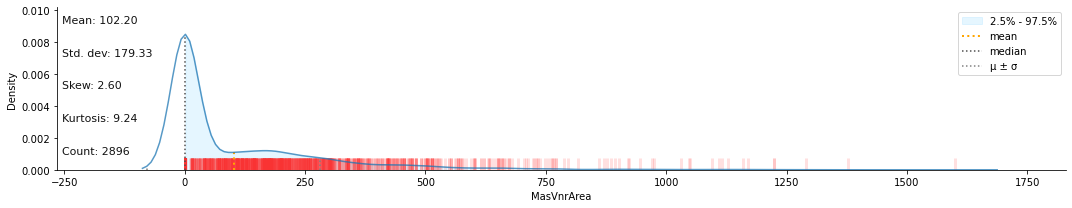

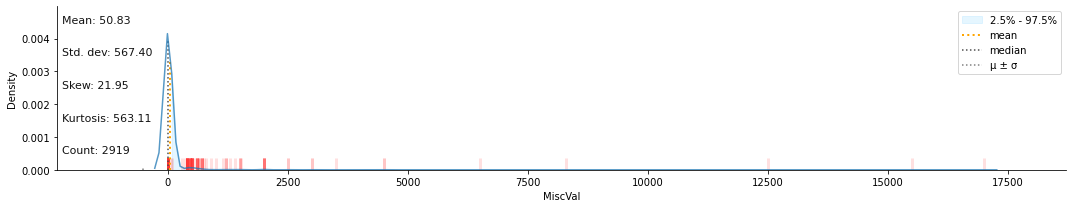

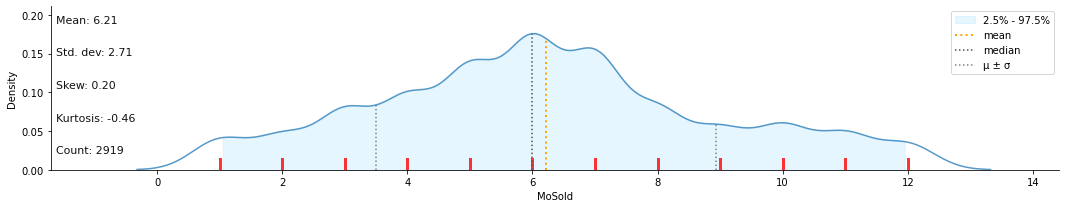

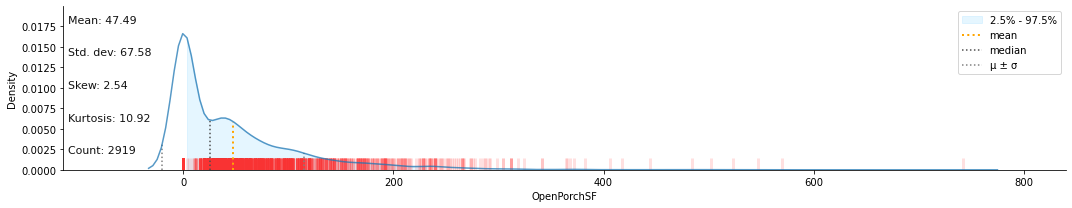

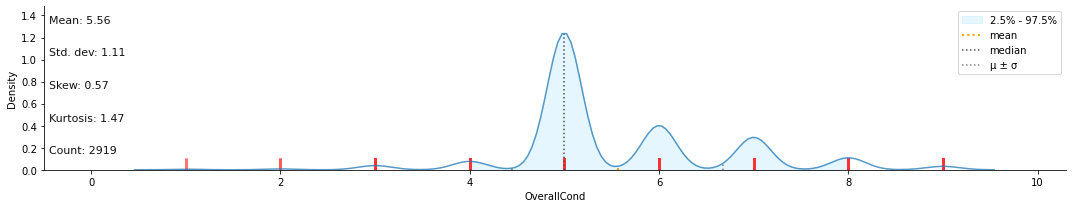

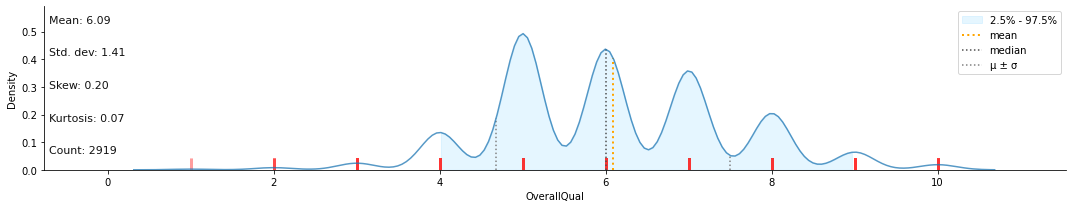

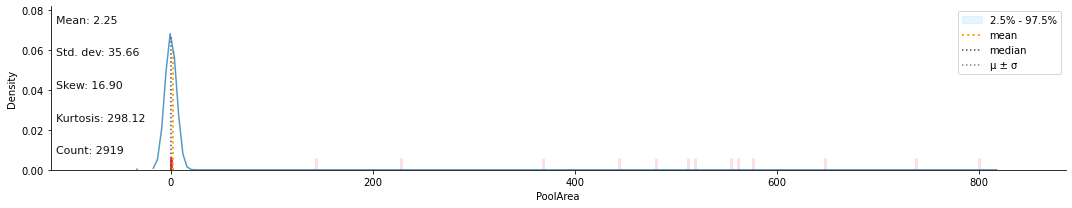

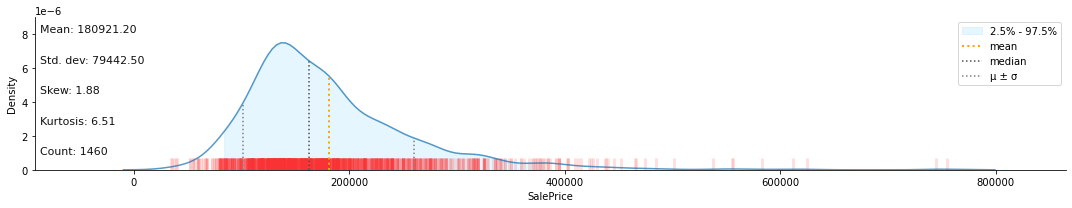

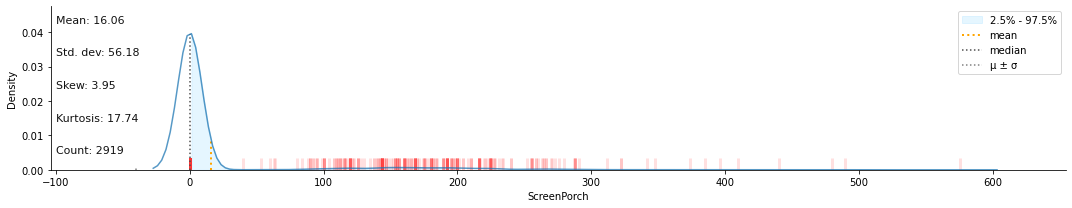

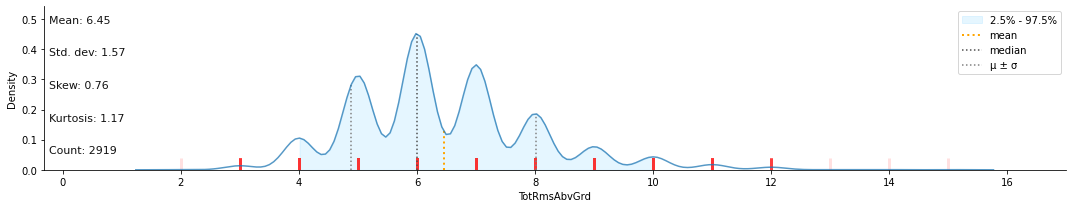

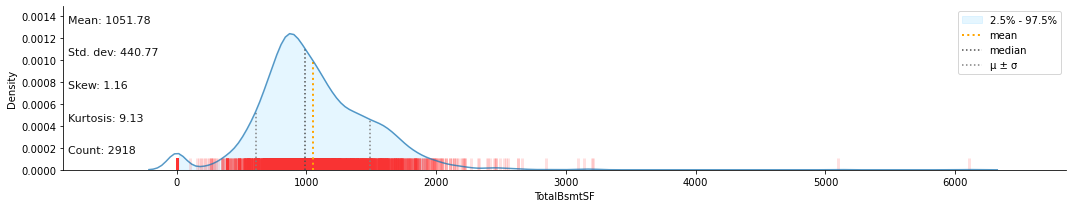

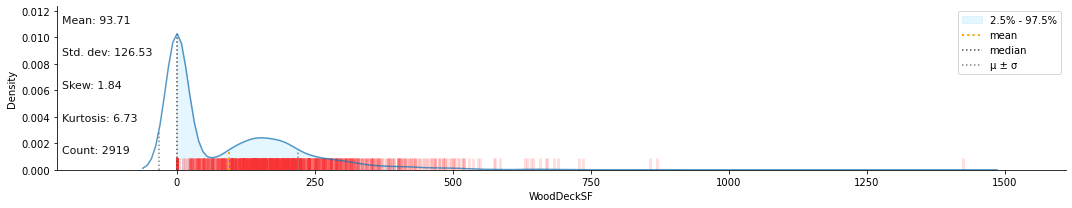

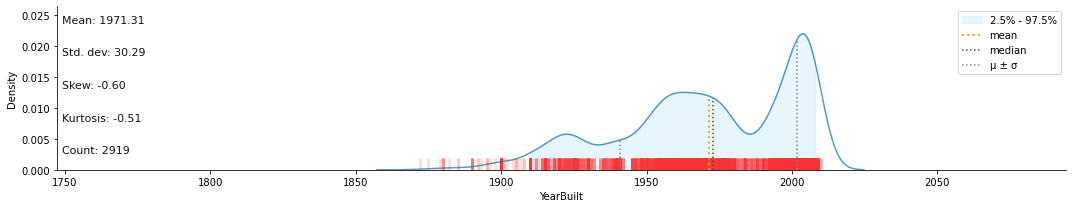

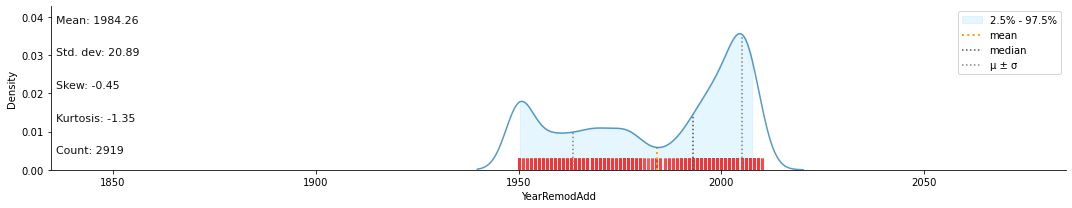

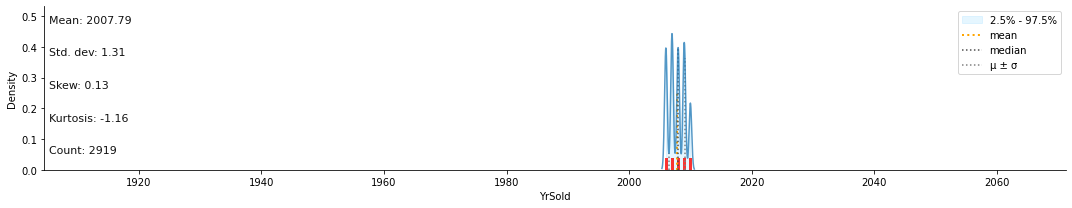

In [24]:
#Skewness of the features can be detected using density plot of each feature
klib.dist_plot(df_num,showall=True)

In [25]:
df_merged_num = df_merged.select_dtypes(include = ['int64', 'float64'])


In [26]:
# Transforming 
df_merged_skewed = np.log1p(df_merged_num[df_merged_num.skew()[df_merged_num.skew()>0.75].index])
df_merged_normal = df_merged_num[df_merged_num.skew()[df_merged_num.skew()< 0.75].index] # Normal variables
df_merged_num_all = pd.concat([df_merged_skewed, df_merged_normal], axis = 1)
df_merged_num.update(df_merged_num_all)

C:\Users\ADMIN\anaconda3\lib\site-packages\pandas\core\frame.py:7511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


<h1> Bivariate Analysis</h1>

In [27]:
df_corr = pd.concat([df_merged.iloc[0:1456, :], y_train], axis = 1)
df_corr = df_corr.agg(LabelEncoder().fit_transform)
df_corr = df_corr.corr()
# df_corr.SalePrice

In [28]:
# Most postive and negative correlated features with SalePrice
corr_positive = df_corr.loc[:, ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']]
corr_neg = df_corr.loc[:, ['SalePrice', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageType', 'GarageFinish']]

# Correlation between categorical and numerical variables
corr_cat = df_merged.loc[:, ['OverallQual', 'GarageCars', 'FullBath', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageType', 'GarageFinish', 'HeatingQC', 'BsmtExposure', 'LotShape', 'MSZoning', 'KitchenAbvGr']]
corr_cat = corr_cat.iloc[0:1456, :]

<h1> Feature Engineering </h1>

In [29]:
# Checking multicollinearity using varince inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
temp2 = df_merged_num.copy()
temp2 = temp2.assign(const=1)
# pd.Series([variance_inflation_factor(temp2.values, i) for i in range(temp2.shape[1])], index=temp2.columns)

In [30]:
df_merged_num['TotalSF'] = df_merged_num['TotalBsmtSF'] + df_merged_num['1stFlrSF'] + df_merged_num['2ndFlrSF']

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_11896/3112732949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_num['TotalSF'] = df_merged_num['TotalBsmtSF'] + df_merged_num['1stFlrSF'] + df_merged_num['2ndFlrSF']


In [31]:
#GrLivArea is an important feature

In [32]:
# Standardizing Numerical features 
robust_scl = RobustScaler()
robust_scl.fit(df_merged_num)
df_merged_num_scaled = robust_scl.transform(df_merged_num)
df_merged_num_scaled = pd.DataFrame(data = df_merged_num_scaled, columns = df_merged_num.columns, index = df_merged_num.index)
# df_merged_num_scaled

In [33]:
df_merged.shape

(2915, 79)

In [34]:
# Encoding categorical feaures
#label encoding features
df_merged_cat = df_merged.select_dtypes(include = ['object']).astype('category')
df_merged_cat.LotShape.replace(to_replace = ['IR3', 'IR2', 'IR1', 'Reg'], value = [0, 1, 2, 3], inplace = True)
df_merged_cat.LandContour.replace(to_replace = ['Low', 'Bnk', 'HLS', 'Lvl'], value = [0, 1, 2, 3], inplace = True)
df_merged_cat.Utilities.replace(to_replace = ['NoSeWa', 'AllPub'], value = [0, 1], inplace = True)
df_merged_cat.LandSlope.replace(to_replace = ['Sev', 'Mod', 'Gtl'], value = [0, 1, 2], inplace = True)
df_merged_cat.ExterQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
df_merged_cat.ExterCond.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
df_merged_cat.BsmtQual.replace(to_replace = ['None', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
df_merged_cat.BsmtCond.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd'], value = [0, 1, 2, 3, 4], inplace = True)
df_merged_cat.BsmtExposure.replace(to_replace = ['None', 'No', 'Mn', 'Av', 'Gd'], value = [0, 1, 2, 3, 4], inplace = True)
df_merged_cat.BsmtFinType1.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
df_merged_cat.BsmtFinType2.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
df_merged_cat.HeatingQC.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
df_merged_cat.Electrical.replace(to_replace = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], value = [0, 1, 2, 3, 4], inplace = True)
df_merged_cat.KitchenQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
df_merged_cat.Functional.replace(to_replace = ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
df_merged_cat.FireplaceQu.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
df_merged_cat.GarageFinish.replace(to_replace =  ['None', 'Unf', 'RFn', 'Fin'], value = [0, 1, 2, 3], inplace = True)
df_merged_cat.GarageQual.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
df_merged_cat.GarageCond.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
df_merged_cat.PavedDrive.replace(to_replace =  ['N', 'P', 'Y'], value = [0, 1, 2], inplace = True)
df_merged_cat.PoolQC.replace(to_replace =  ['None', 'Fa', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
df_merged_cat.Fence.replace(to_replace =  ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], value = [0, 1, 2, 3, 4], inplace = True)

In [37]:
df_merged_cat.dtypes
#out of all features to encode in label type only OverallQual and OverallCond are not int64 type
df_merged_cat.loc[:, ['OverallQual', 'OverallCond']] = df_merged_cat.loc[:, ['OverallQual', 'OverallCond']].astype('int64')
df_merged_label_encoded = df_merged_cat.select_dtypes(include = ['int64'])

In [38]:
# one hot encoding nominal features
df_merged_one_hot = df_merged_cat.select_dtypes(include = ['category'])
df_merged_one_hot = pd.get_dummies(df_merged_one_hot)

In [39]:
df_merged_encoded = pd.concat([df_merged_one_hot, df_merged_label_encoded], axis = 1)


In [40]:
df_merged_processed = pd.concat([df_merged_num_scaled, df_merged_encoded], axis = 1)

In [41]:
df_train_final = df_merged_processed.iloc[0:1456, :]
df_test_final = df_merged_processed.iloc[1456:, :]
y_train = y_train

In [42]:
svm = SVR()
rf =  RandomForestRegressor(n_jobs = -1, random_state = 43,)
xgb = XGBRegressor(random_state = 43, n_jobs = -1)

In [43]:
def train_r2(model):
    model.fit(df_train_final, y_train)
    return model.score(df_train_final, y_train)

In [44]:
#R square
print(train_r2(svm))
print(train_r2(rf))
print(train_r2(xgb))

0.9449579689999049
0.9836218924335669
0.9987867198592015


In [45]:
def train_test_split_score(model):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(df_train_final, y_train, test_size = 0.3, random_state = 43)
    model.fit(X_train, Y_train)
    prediction = model.predict(X_test)
    mse = mean_squared_error(prediction, Y_test)
    rmse = np.sqrt(mse)
    return rmse

In [46]:
# train_test_spli score
print(train_test_split_score(svm))
print(train_test_split_score(rf))
print(train_test_split_score(xgb))

0.11252829908527022
0.13704532457173293
0.13611089698758808


In [47]:
def cross_validate(model):
    from sklearn.model_selection import cross_val_score
    neg_x_val_score = cross_val_score(model, df_train_final, y_train, cv = 10, n_jobs = -1, scoring = 'neg_mean_squared_error')
    x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    return x_val_score.mean()

In [48]:
#Cross validation
def cross_validate(model):
    from sklearn.model_selection import cross_val_score
    neg_x_val_score = cross_val_score(model, df_train_final, y_train, cv = 10, n_jobs = -1, scoring = 'neg_mean_squared_error')
    x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    return x_val_score.mean()

In [49]:
# Cross validation score
print(cross_validate(svm))
print(cross_validate(rf))
print(cross_validate(xgb))

0.113872
0.134569
0.12940899999999997


In [50]:
# Hyperparameter tunning
def grid_search_cv(model, params):
    global best_params, best_score
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = 10, verbose = 1,
                            scoring = 'neg_mean_squared_error', n_jobs = -1)
    grid_search.fit(df_train_final, y_train)
    best_params = grid_search.best_params_ 
    best_score = np.sqrt(-1*(np.round(grid_search.best_score_, 5)))
    return best_params, best_score

In [51]:
svm_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # precomputed is omitted from kernel to avoid error.
    'C': [4, 5], 
    'gamma':[0.0001, 0.001]}

rf_params = {'n_estimators':[50,100,250,500]}
xgb_params = {'colsample_bytree' : [0.4,0.4603,0.47], 'gamma' : [0.4,0.4603,0.0468,0.47], 
                             'learning_rate' : [0.01,0.02,0.03,0.04,0.05], 'max_depth' : [1,2,3], 
                             'min_child_weight' : [1.7817,1.79,1.80], 'n_estimators' : [1000,1500,2000,2500,3000,3500],
                             'reg_alpha' : [0.4640,0.4635,0.4645], 'reg_lambda' : [0.8561,0.8571,0.8581],
                             'subsample' : [0.5211,0.5213,0.5215], 'silent' : [1,2,3]}


In [52]:
xgb_opt = XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.04, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2500,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, silent = 1,
                             nthread = -1, random_state = 7)


rf_opt = RandomForestRegressor(n_jobs = -1, random_state = 43,n_estimators=100)
svm_opt= SVR(kernel='rbf',gamma=0.001, C=5)


In [53]:
print(cross_validate(svm_opt))
print(cross_validate(rf_opt))
print(cross_validate(xgb_opt))

0.11077600000000001
0.134569
0.11312


In [54]:
# using SVM
svm_opt.fit(df_train_final,y_train)
y_pred = np.exp(svm_opt.predict(df_test_final))
s1 = pd.DataFrame()
s1['Id']= [i+1 for i in range(0,1459)]
s1['SalePrice'] = y_pred


In [55]:
rf_opt.fit(df_train_final,y_train)
y_pred = np.exp(rf_opt.predict(df_test_final))
s2 = pd.DataFrame()
s2['Id']= [i+1 for i in range(0,1459)]
s2['SalePrice'] = y_pred


In [56]:
xgb_opt.fit(df_train_final,y_train)
y_pred = np.exp(xgb_opt.predict(df_test_final))
s3 = pd.DataFrame()
s3['Id']= [i+1 for i in range(0,1459)]
s3['SalePrice'] = y_pred


[21:39:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


